# IMPORT LIBRARIES

In [1]:
import sys
sys.path.append("../")
import config

import os
import random
import math
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from statistics import mean



# CHANNELS INFO
channels = config.channels
input_channels = config.weather_channels+config.sf_channels
#input_channels = config.weather_channels[:2]#+config.sf_channels
static_channels = config.static_channels

# TIME SERIES INFO
window = config.window

# TRAIN INFO
device = config.device
code_dim = config.code_dim
n_clusters = config.n_clusters
epochs = config.epochs
batch_size = config.batch_size
learning_rate = config.learning_rate
alpha = config.alpha

# MODEL INFO
recon_weight = 1#config.recon_weight
static_weight = 1#config.static_weight
triplet_weight = 1# config.triplet_weight
sum_weight = recon_weight+static_weight+triplet_weight
# architecture = "LAST"
architecture = "ATT_NL"

temp =1
num_runs =5
run =1
num_hidden =131
num_layer =1
Hidden="Hidden_{}_Serial_contrastive".format(num_hidden)
# MODEL NAME
model_name = "{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format("ALL", architecture, code_dim, len(static_channels), run,batch_size,"{}_NL".format(num_layer),Hidden,recon_weight,static_weight,triplet_weight,temp)
pretrain = None

print("{} Hyperparameters".format(model_name))
print("Channels : {}".format(channels))
print("Input Channels : {}".format(input_channels))
print("Static Channels : {}".format(static_channels))
print("Code dim : {}".format(code_dim))
print("Epochs : {}".format(epochs))
print("Batch Size : {}".format(batch_size))
print("Learning rate : {}".format(learning_rate))
print("Reconstruction Weight : {}".format(recon_weight))
print("Static Weight : {}".format(static_weight))
print("Triplet Weight : {}".format(triplet_weight))
print("Pretrain : {}".format(pretrain))

if not os.path.exists(os.path.join(config.MODEL_DIR)):
    os.makedirs(os.path.join(config.MODEL_DIR))
if not os.path.exists(os.path.join(config.RESULT_DIR)):
    os.makedirs(os.path.join(config.RESULT_DIR))

ALL_ATT_NL_32_27_1_200_1_NL_Hidden_131_Serial_contrastive_1_1_1_1 Hyperparameters
Channels : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Input Channels : [27, 28, 29, 30, 31, 32]
Static Channels : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Code dim : 32
Epochs : 200
Batch Size : 200
Learning rate : 0.005
Reconstruction Weight : 1
Static Weight : 1
Triplet Weight : 1
Pretrain : None


# LOAD DATA

In [2]:
train_data = np.load(os.path.join(config.NUMPY_DIR, "train_data_basin_ealstm.npy"))[:-num_hidden,:,:,:-1]
test_basin_train_period = np.load(os.path.join(config.NUMPY_DIR, "train_data_basin_ealstm.npy"))[-num_hidden:,:,:,:-1]
validation_data = np.load(os.path.join(config.NUMPY_DIR, "validation_data_basin_ealstm.npy"))[:-num_hidden,:,:,:-1]
test_data = np.load(os.path.join(config.NUMPY_DIR, "test_data_basin_ealstm.npy"))[-num_hidden:,:,:,:-1]
print("Train Data:{}\tValidation Data:{}\tTest Data:{}".format(train_data.shape, validation_data.shape, test_data.shape))

feature_names = np.load(os.path.join(config.DATA_DIR, "RAW_DATA", "feature_names.npy"), allow_pickle=True)
print("Static features:{}".format(feature_names[config.static_channels]))
print("Weather features:{}".format(feature_names[config.weather_channels]))
print("SF features:{}".format(feature_names[config.sf_channels]))

Train Data:(400, 13, 365, 33)	Validation Data:(400, 3, 365, 33)	Test Data:(131, 19, 365, 33)
Static features:['p_mean' 'pet_mean' 'p_seasonality' 'frac_snow' 'aridity'
 'high_prec_freq' 'high_prec_dur' 'low_prec_freq' 'low_prec_dur'
 'carbonate_rocks_frac' 'geol_permeability' 'soil_depth_pelletier'
 'soil_depth_statsgo' 'soil_porosity' 'soil_conductivity'
 'max_water_content' 'sand_frac' 'silt_frac' 'clay_frac' 'elev_mean'
 'slope_mean' 'area_gages2' 'frac_forest' 'lai_max' 'lai_diff' 'gvf_max'
 'gvf_diff']
Weather features:['PRCP(mm/day)' 'SRAD(W/m2)' 'Tmax(C)' 'Tmin(C)' 'Vp(Pa)']
SF features:['SF']


In [3]:
class SimCLR_Loss(torch.nn.Module):
    def __init__(self, temperature):
        super(SimCLR_Loss, self).__init__()
        self.temperature = temperature
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")
        self.similarity = torch.nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z):
        
        N = z.shape[0]
        batch_size = N//2

        sim = self.similarity(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        mask = self.mask_correlated_samples(batch_size)
        negative_samples = sim[mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

# BUILD MODEL

In [4]:
class ATT_NL(torch.nn.Module):
    def __init__(self, in_channels, stat_channels, code_dim, device):
        super(ATT_NL,self).__init__()
        
        self.code_dim = code_dim
        self.device = device
        self.encoder = torch.nn.GRU(in_channels, code_dim,num_layers=num_layer, batch_first=True, bidirectional=True)
        self.att = torch.nn.Linear(code_dim, 1)
        self.decoder = torch.nn.GRU(in_channels, code_dim, batch_first=True)
        self.out = torch.nn.Linear(code_dim, in_channels)
        self.linear_1 = torch.nn.Linear(code_dim,code_dim)
        #self.linear_2 = torch.nn.Linear(code_dim,code_dim)
        self.static_out = torch.nn.Linear(code_dim, stat_channels)
        self.relu = torch.nn.ReLU()

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
    
    def forward(self, x):
        batch, seq_len, in_channels = x.shape
        
        code_vec, _ = self.encoder(x)
        code_vec = torch.add(code_vec[:,:,:self.code_dim], code_vec[:,:,self.code_dim:])
        att_weights = torch.unsqueeze(torch.nn.functional.softmax(self.att(code_vec).squeeze(), dim=1), dim=-1)
        code_vec = att_weights*code_vec
        code_vec = torch.unsqueeze(torch.sum(code_vec, dim=1), dim=0)
        static_out = self.relu(self.linear_1(code_vec.squeeze()))
        #static_out = self.relu(self.linear_2(static_out))
        static_out = self.static_out(static_out)

        out = torch.zeros(batch, seq_len, in_channels).to(self.device)
        h = code_vec
        input = torch.zeros((batch, 1, in_channels)).to(self.device)
        for step in range(seq_len):
            input, h = self.decoder(input, h)
            output = self.out(torch.mul(input.squeeze(), code_vec.squeeze()))
            out[:,step] = output
            input = output.unsqueeze(1)
        
        out = out.view(batch, seq_len, in_channels)
        return code_vec.squeeze().view(batch, -1), out, static_out     

    
class LAST(torch.nn.Module):
    def __init__(self, in_channels, stat_channels, code_dim, device):
        super(LAST,self).__init__()
        
        self.code_dim = code_dim
        self.device = device
        self.encoder = torch.nn.GRU(in_channels, code_dim, batch_first=True, bidirectional=True)
        self.decoder = torch.nn.GRU(in_channels, code_dim, batch_first=True)
        self.out = torch.nn.Linear(code_dim, in_channels)
        self.static_out = torch.nn.Linear(code_dim, stat_channels)

        self.encoder = torch.nn.GRU(in_channels, code_dim, batch_first=True, bidirectional=True)
        self.decoder = torch.nn.GRU(in_channels, code_dim, batch_first=True)
        self.out = torch.nn.Linear(code_dim, in_channels)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
    
    def forward(self, x):
        batch, seq_len, in_channels = x.shape
        
        _, code_vec = self.encoder(x)
        code_vec = torch.unsqueeze(torch.sum(code_vec, dim=0), dim=0)
        static_out = self.static_out(code_vec.squeeze())

        out = torch.zeros(batch, seq_len, in_channels).to(self.device)
        h = code_vec
        input = torch.zeros((batch, 1, in_channels)).to(self.device)
        for step in range(seq_len):
            input, h = self.decoder(input, h)
            output = self.out(torch.mul(input.squeeze(), code_vec.squeeze()))
            out[:,step] = output
            input = output.unsqueeze(1)
        
        out = out.view(batch, seq_len, in_channels)
        return code_vec.squeeze().view(batch, -1), out, static_out

model = globals()[architecture](in_channels=len(input_channels), stat_channels=len(static_channels), code_dim=code_dim, device=device)
model = model.to(device)
criterion = torch.nn.MSELoss(reduction="none")
contrastive_criterion = SimCLR_Loss(temperature=temp)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters:{}".format(pytorch_total_params))

Total trainable parameters:13698


# TEST MODEL

## LOAD TRAINED MODEL

In [5]:
model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR, "{}.pt".format(model_name))))
model.eval()

# weights = model.static_out.weight.detach().cpu().numpy()
# print(weights.shape)
# plt.imshow(weights)
# plt.colorbar()

ATT_NL(
  (encoder): GRU(6, 32, batch_first=True, bidirectional=True)
  (att): Linear(in_features=32, out_features=1, bias=True)
  (decoder): GRU(6, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=6, bias=True)
  (linear_1): Linear(in_features=32, out_features=32, bias=True)
  (static_out): Linear(in_features=32, out_features=27, bias=True)
  (relu): ReLU()
)

# RUN MODEL

In [6]:
dataset = train_data[:,:13]
reconstructed_dataset_all_runs = np.zeros((num_runs,dataset.shape[0], (1+(dataset.shape[1]//2))* dataset.shape[2], dataset.shape[3])).astype(np.float32)
for runs in range(1,(num_runs+1)):

    model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR,"{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}.pt".format("ALL", architecture, code_dim, len(static_channels), runs,batch_size,"{}_NL".format(num_layer),Hidden,recon_weight,static_weight,triplet_weight,temp))))
    model.eval()
    reconstructed_dataset1 = np.zeros((dataset.shape[0], (1+(dataset.shape[1]//2)), dataset.shape[2], dataset.shape[3])).astype(np.float32)
    input_dataset = np.zeros_like(reconstructed_dataset1).astype(np.float32)
    embedding = np.zeros((dataset.shape[0], dataset.shape[1], code_dim)).astype(np.float32)

    """Run model"""
    total_out = np.zeros((dataset.shape[0], dataset.shape[1], dataset.shape[2], dataset.shape[3])).astype(np.float32)
    train_static_out = np.zeros((dataset.shape[0],len(static_channels),dataset.shape[1])).astype(np.float32)
    train_static_input = np.zeros((dataset.shape[0],len(static_channels))).astype(np.float32)
    total_recon_loss = 0
    total_static_loss = 0
    for year in range(dataset.shape[1]):
        yearly_data = dataset[:, year]
        for batch in range(math.ceil(yearly_data.shape[0]/batch_size)):
            data = torch.from_numpy(yearly_data[batch*batch_size:(batch+1)*batch_size]).to(device)
            input_data = data[:,:,input_channels]
            static_data = data[:,0,static_channels]
            code_vec, reconstruction, static_reconstruction_mean = model(input_data.to(device))
            static_reconstruction = static_reconstruction_mean

            # Calculate reconstruction loss
            recon_loss = torch.sum(criterion(reconstruction, input_data), axis=2)
            recon_loss = torch.masked_select(recon_loss, (input_data[:,:,-1]!=config.unknown))
            recon_loss = torch.mean(recon_loss)
            total_recon_loss += recon_loss.item()

            # Calculate static loss
            static_loss = torch.mean(criterion(static_reconstruction, static_data), axis=1)
            static_loss = torch.masked_select(static_loss, (input_data[:,:,-1]!=config.unknown).all(axis=1))
            static_loss = torch.mean(static_loss)
            total_static_loss += static_loss.item()

            # Store outputs
            embedding[batch*batch_size:(batch+1)*batch_size,year] = code_vec.detach().cpu().numpy()
            total_out[batch*batch_size:(batch+1)*batch_size, year][:, :, input_channels] = reconstruction.detach().cpu().numpy()
            total_out[batch*batch_size:(batch+1)*batch_size, year][:, :, static_channels] = static_reconstruction.unsqueeze(dim=1).repeat(1, config.window, 1).detach().cpu().numpy()
            train_static_input[batch*batch_size:(batch+1)*batch_size] = static_data.cpu().numpy()
            #print(static_reconstruction.unsqueeze(dim=1).repeat(1, config.window, 1).detach().cpu().numpy().mean(axis=1)[35][10])

            train_static_out[batch*batch_size:(batch+1)*batch_size,:,year] = static_reconstruction.detach().cpu().numpy()
            #print(static_reconstruction.detach().cpu().numpy()[35][10])


            # Make unknown values to be NaN
            embedding[batch*batch_size:(batch+1)*batch_size,year][(input_data[:,:,-1]==config.unknown).all(axis=1).cpu().numpy()] = np.nan
            total_out[batch*batch_size:(batch+1)*batch_size, year][(input_data[:,:,-1]==config.unknown).all(axis=1).cpu().numpy()] = np.nan
    print('Reconstruction MSE:{:.4f}\tStatic MSE:{:.4f}'.format(total_recon_loss/((batch+1)*(year+1)), total_static_loss/((batch+1)*(year+1))))
    reconstructed_dataset1[:,:,:config.window//2+1] = total_out[:,::2][:,:,-(config.window//2)-1:]
    reconstructed_dataset1[:,:,config.window//2+1:] = np.concatenate((total_out[:,1::2][:,:,-(config.window//2):], np.zeros((dataset.shape[0],1,config.window//2, dataset.shape[3]))), axis=1)
    input_dataset[:,:,:config.window//2+1] = dataset[:,::2][:,:,-(config.window//2)-1:]
    input_dataset[:,:,config.window//2+1:] = np.concatenate((dataset[:,1::2][:,:,-(config.window//2):], np.zeros((dataset.shape[0],1,config.window//2, dataset.shape[3]))), axis=1)
    reconstructed_dataset1 = np.reshape(reconstructed_dataset1, (reconstructed_dataset1.shape[0], -1, reconstructed_dataset1.shape[3]))
    input_dataset = np.reshape(input_dataset, (input_dataset.shape[0], -1, input_dataset.shape[3]))
    #train_static = train_static_out[38]
    dummy = train_static_out[:,:,:-1]
    train_static = dummy.mean(axis = 2) 
    #train_static = train_static_out.mean(axis = 2) 
    print(train_static_out.mean(axis = 2).shape)
    print(dataset.shape, total_out.shape, reconstructed_dataset1.shape, input_dataset.shape, embedding.shape)  
    reconstructed_dataset_all_runs[runs-1] = reconstructed_dataset1

Reconstruction MSE:2.0970	Static MSE:0.1943
(400, 27)
(400, 13, 365, 33) (400, 13, 365, 33) (400, 2555, 33) (400, 2555, 33) (400, 13, 32)
Reconstruction MSE:2.0846	Static MSE:0.1791
(400, 27)
(400, 13, 365, 33) (400, 13, 365, 33) (400, 2555, 33) (400, 2555, 33) (400, 13, 32)
Reconstruction MSE:2.0732	Static MSE:0.1830
(400, 27)
(400, 13, 365, 33) (400, 13, 365, 33) (400, 2555, 33) (400, 2555, 33) (400, 13, 32)
Reconstruction MSE:2.0835	Static MSE:0.1879
(400, 27)
(400, 13, 365, 33) (400, 13, 365, 33) (400, 2555, 33) (400, 2555, 33) (400, 13, 32)
Reconstruction MSE:2.0788	Static MSE:0.2044
(400, 27)
(400, 13, 365, 33) (400, 13, 365, 33) (400, 2555, 33) (400, 2555, 33) (400, 13, 32)


In [7]:
mean_reconstructed_dataset_all_runs= np.nanmean(reconstructed_dataset_all_runs,axis=0)
mean_reconstructed_dataset_all_runs.shape

(400, 2555, 33)

In [8]:
std_original_data = np.load(os.path.join(config.RESULT_DIR, "std_original_data.npy"), allow_pickle=True)
mean_original_data = np.load(os.path.join(config.RESULT_DIR, "Mean__original_data.npy"), allow_pickle=True)

In [9]:
# input_dataset[basin,:,-1][input_dataset[basin,:,-1]!=config.unknown][:-(config.window)].shape

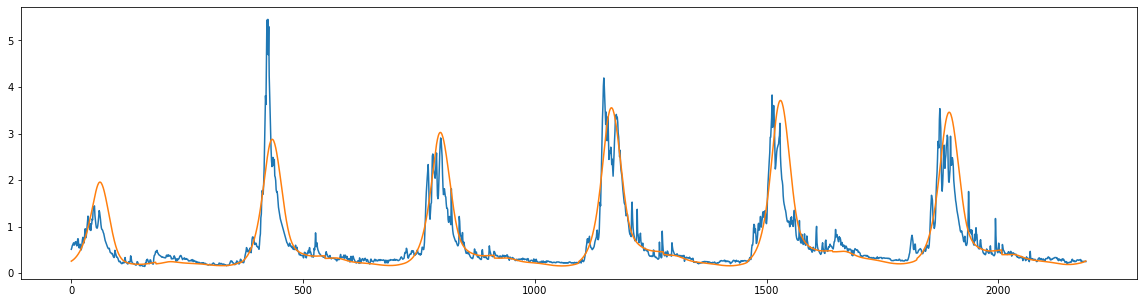

In [10]:
basin = 50
#basin = 136
fig = plt.figure(figsize=(20, 5))
plt.plot(10**(input_dataset[basin,:,-1][input_dataset[basin,:,-1]!=config.unknown][:-(config.window)]*std_original_data[0,0,32]+mean_original_data[0,0,32]))
plt.plot(10**(mean_reconstructed_dataset_all_runs[basin,:,-1][input_dataset[basin,:,-1]!=config.unknown][:-(config.window)]*std_original_data[0,0,32]+mean_original_data[0,0,32]))

# plt.plot(input_dataset[basin][input_dataset[basin]!=config.unknown][:-(config.window)])
# plt.plot(mean_reconstructed_dataset_all_runs[basin][input_dataset[basin]!=config.unknown][:-(config.window)])
#plt.savefig(os.path.join(config.RESULT_DIR, "{}_Basin135BadPlot".format(model_name)))
plt.show()

In [11]:
# #Only 1 Run
# basin = 50
# #basin = 136
# fig = plt.figure(figsize=(20, 5))
# plt.plot(10**(input_dataset[basin,:,-1][input_dataset[basin,:,-1]!=config.unknown][:-(config.window)]*std_original_data[0,0,32]+mean_original_data[0,0,32]))
# plt.plot(10**(reconstructed_dataset_all_runs[1][basin,:,-1][input_dataset[basin,:,-1]!=config.unknown][:-(config.window)]*std_original_data[0,0,32]+mean_original_data[0,0,32]))

# # plt.plot(input_dataset[basin][input_dataset[basin]!=config.unknown][:-(config.window)])
# # plt.plot(mean_reconstructed_dataset_all_runs[basin][input_dataset[basin]!=config.unknown][:-(config.window)])
# #plt.savefig(os.path.join(config.RESULT_DIR, "{}_Basin135BadPlot".format(model_name)))
# plt.show()

Train Data:(400, 13, 365, 33)	Validation Data:(400, 3, 365, 33)	Test Data:(131, 19, 365, 33)


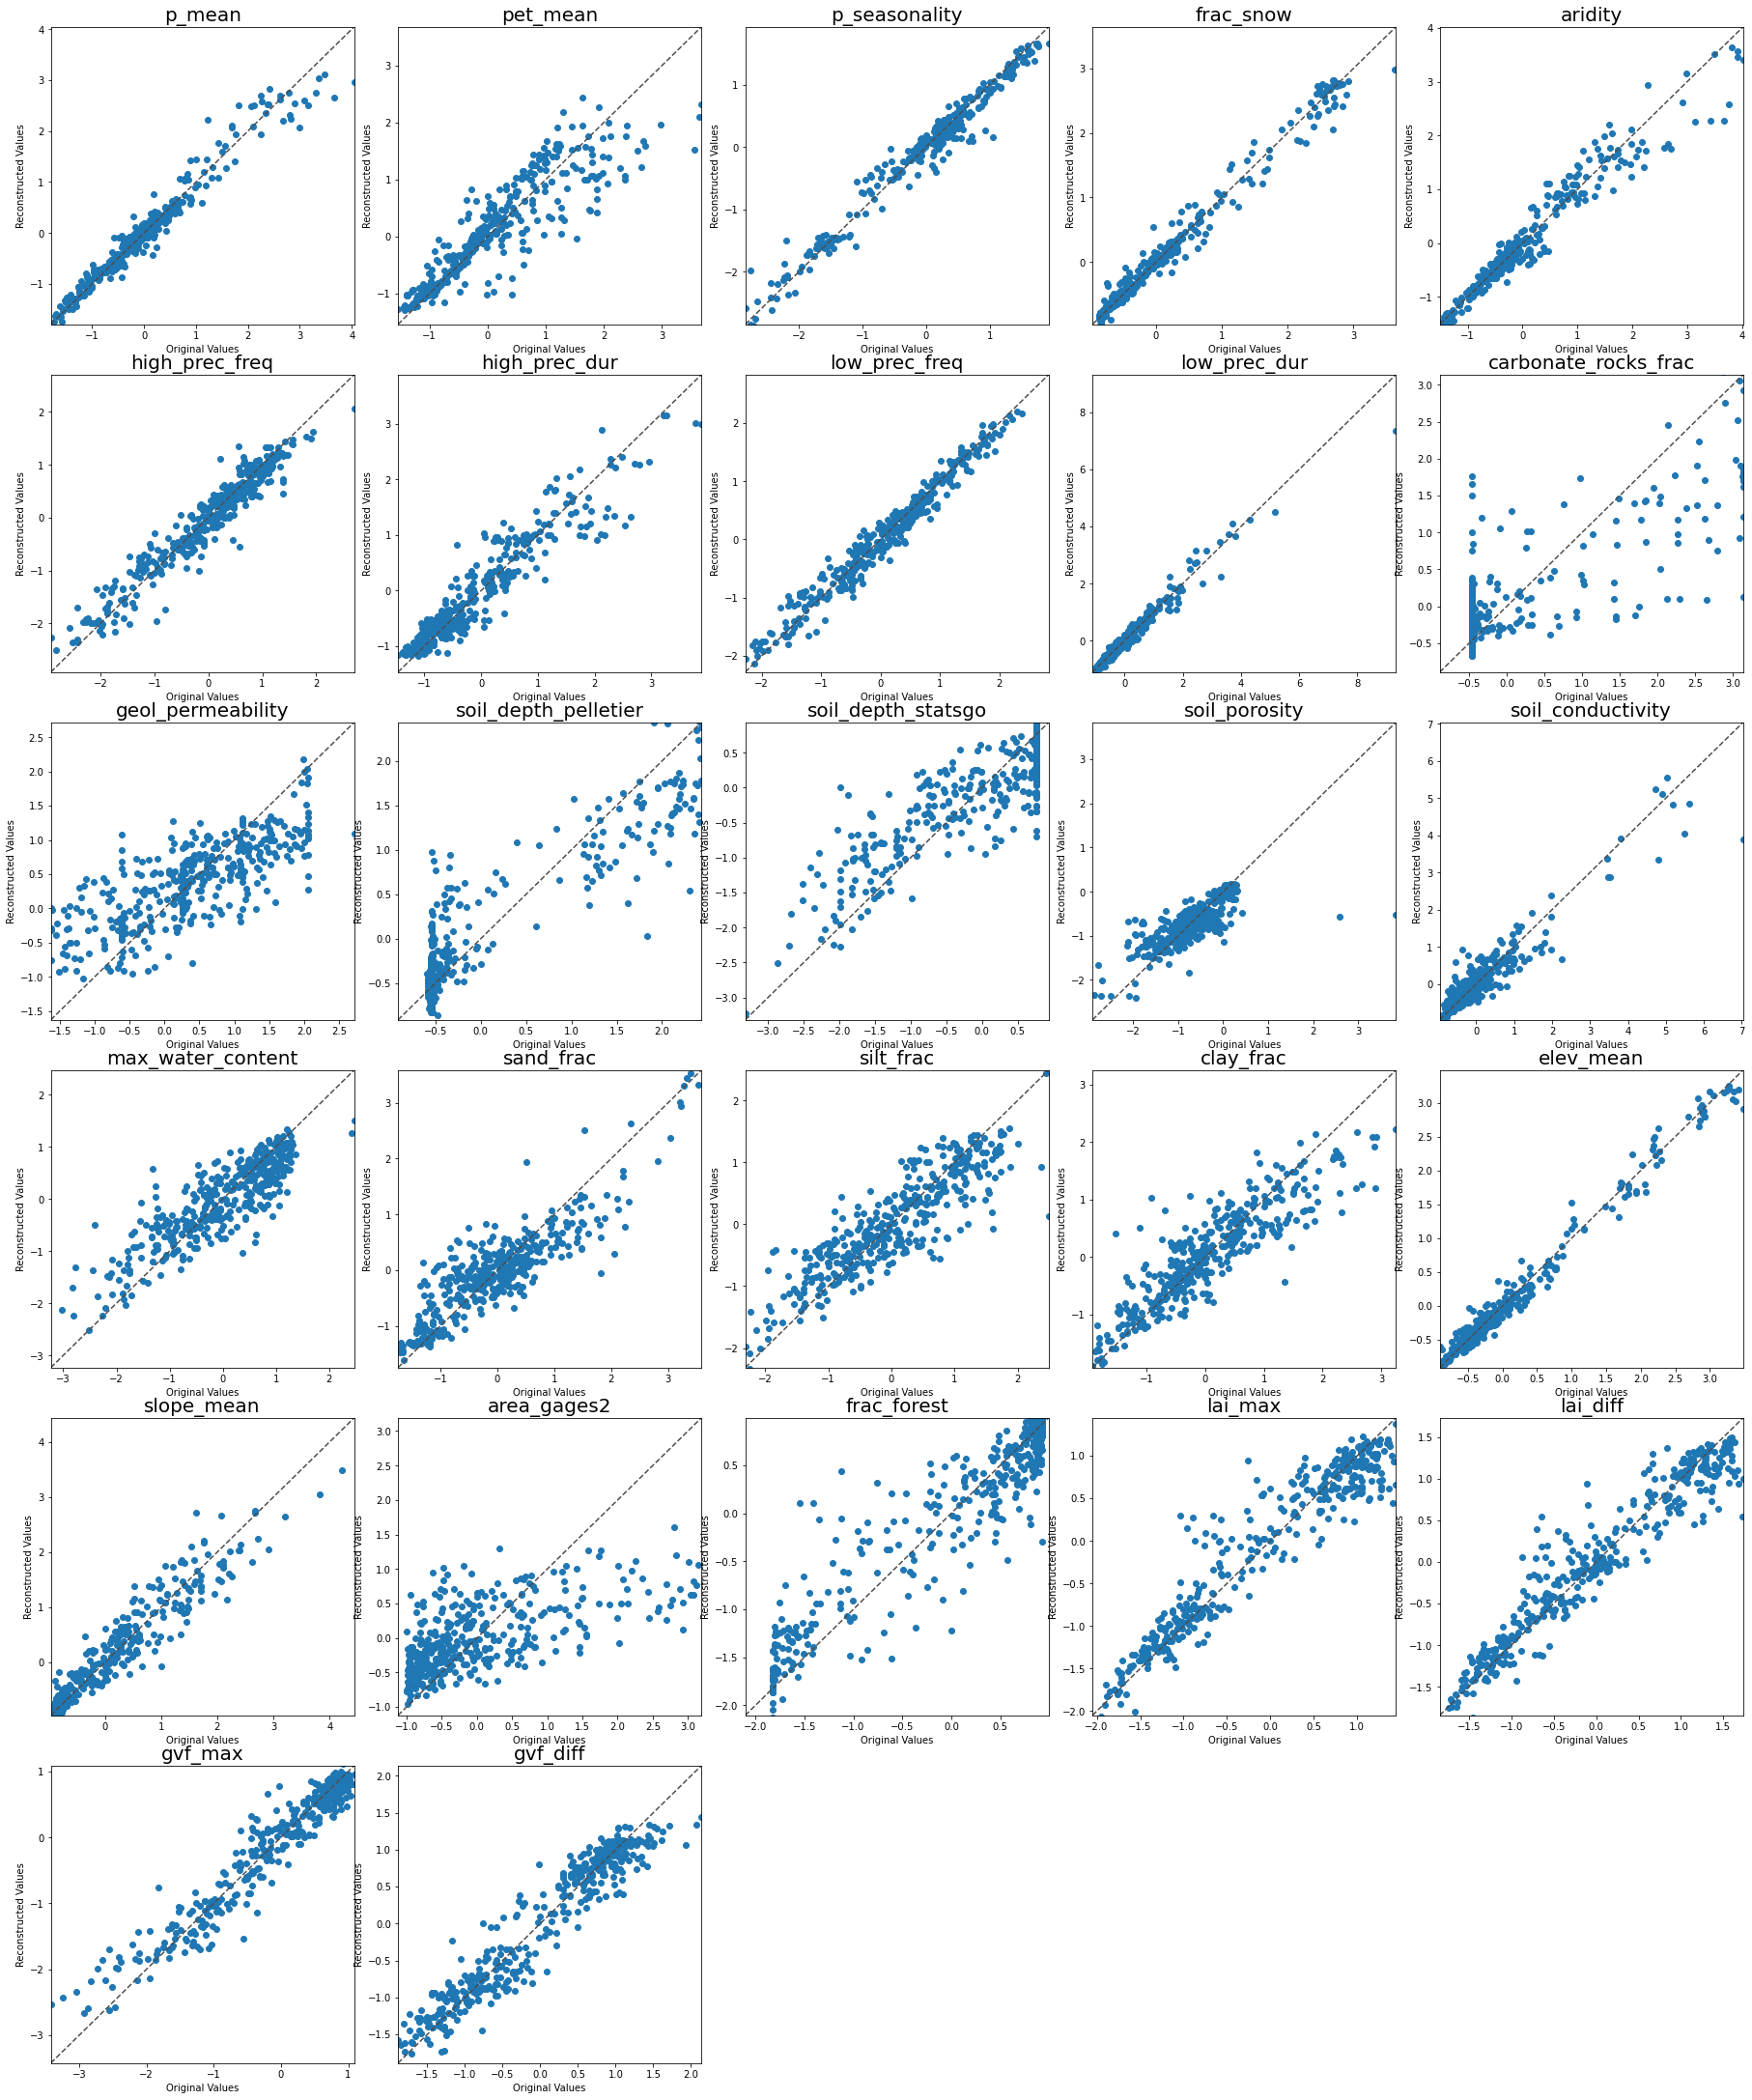

[0.20632385167750786, 0.4530567374466167, 0.17193193715385932, 0.13754835631603585, 0.24541750207195184, 0.2784759733061255, 0.33372503392065195, 0.1884788164448979, 0.18655048638343522, 0.6105728901906482, 0.6284311925658369, 0.4084366547126075, 0.5114187872586491, 0.43714585183579335, 0.347515984507261, 0.5081035731637272, 0.48828304731909866, 0.48888168242294633, 0.4830460827069978, 0.12995875781397448, 0.2873091853977128, 0.7771462454623004, 0.3700171496031234, 0.30144060388383137, 0.2850667492770164, 0.26637428179471556, 0.2776411813634987]
0.3632703183704008


In [12]:
#PLOT Predicted vs Real static features
cols = 5
rows = 6
fontsize = 20
plt.figure(figsize=(5*cols, 5*rows))
minx = np.load(os.path.join(config.NUMPY_DIR, "minx.npy"))
maxx = np.load(os.path.join(config.NUMPY_DIR, "maxx.npy"))
miny = np.load(os.path.join(config.NUMPY_DIR, "miny.npy"))
maxy = np.load(os.path.join(config.NUMPY_DIR, "maxy.npy"))
print("Train Data:{}\tValidation Data:{}\tTest Data:{}".format(train_data.shape, validation_data.shape, test_data.shape))
rmse_feature = []
for feature,channel in enumerate(static_channels):
    input_val = np.zeros(input_dataset.shape[0])
    recon_val = np.zeros_like(input_val)
    for basin in range(input_dataset.shape[0]):
        input_val[basin] = input_dataset[basin,0,feature]
        recon_val[basin] = np.nanmean(np.nanmean((reconstructed_dataset_all_runs[:,basin,:-config.window//2,feature]), axis=0 ))
    plt.subplot(rows, cols, feature+1)
    plt.title("{}".format(feature_names[channel]), fontsize=fontsize)
    plt.xlabel("Original Values", fontsize=fontsize//2)
    plt.ylabel("Reconstructed Values", fontsize=fontsize//2)
    plt.ylim(miny[feature], maxy[feature])
    plt.xlim(miny[feature], maxy[feature])
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
    plt.scatter(input_val, recon_val)  
    rmse_feature.append(mean_squared_error(input_val, recon_val,squared=False))
plt.tight_layout(pad=0.0,h_pad=0.0,w_pad=0.0)
model_name2 = "Imputed_{}".format(int(num_hidden))
plt.savefig(os.path.join(config.RESULT_DIR, "{}_Meanwithline20yearsbasin_train".format(model_name2)))
plt.show()
print(rmse_feature)
print(mean(rmse_feature))

In [13]:
#Do predictions for test data during train period
dataset = test_basin_train_period
reconstructed_dataset_all_runs = np.zeros((num_runs,dataset.shape[0], (1+(dataset.shape[1]//2))* dataset.shape[2], dataset.shape[3])).astype(np.float32)
for runs in range(1,(num_runs+1)):
    model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR,"{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}.pt".format("ALL", architecture, code_dim, len(static_channels), runs,batch_size,"{}_NL".format(num_layer),Hidden,recon_weight,static_weight,triplet_weight,temp))))
    model.eval()
    reconstructed_dataset1 = np.zeros((dataset.shape[0], (1+(dataset.shape[1]//2)), dataset.shape[2], dataset.shape[3])).astype(np.float32)
    input_dataset = np.zeros_like(reconstructed_dataset1).astype(np.float32)
    embedding = np.zeros((dataset.shape[0], dataset.shape[1], code_dim)).astype(np.float32)

    """Run model"""
    total_out = np.zeros((dataset.shape[0], dataset.shape[1], dataset.shape[2], dataset.shape[3])).astype(np.float32)
    train_static_out = np.zeros((dataset.shape[0],len(static_channels),dataset.shape[1])).astype(np.float32)
    train_static_input = np.zeros((dataset.shape[0],len(static_channels))).astype(np.float32)
    total_recon_loss = 0
    total_static_loss = 0
    for year in range(dataset.shape[1]):
        yearly_data = dataset[:, year]
        for batch in range(math.ceil(yearly_data.shape[0]/batch_size)):
            data = torch.from_numpy(yearly_data[batch*batch_size:(batch+1)*batch_size]).to(device)
            input_data = data[:,:,input_channels]
            static_data = data[:,0,static_channels]
            code_vec, reconstruction, static_reconstruction_mean = model(input_data.to(device))
            static_reconstruction = static_reconstruction_mean

            # Calculate reconstruction loss
            recon_loss = torch.sum(criterion(reconstruction, input_data), axis=2)
            recon_loss = torch.masked_select(recon_loss, (input_data[:,:,-1]!=config.unknown))
            recon_loss = torch.mean(recon_loss)
            total_recon_loss += recon_loss.item()

            # Calculate static loss
            static_loss = torch.mean(criterion(static_reconstruction, static_data), axis=1)
            static_loss = torch.masked_select(static_loss, (input_data[:,:,-1]!=config.unknown).all(axis=1))
            static_loss = torch.mean(static_loss)
            total_static_loss += static_loss.item()

            # Store outputs
            embedding[batch*batch_size:(batch+1)*batch_size,year] = code_vec.detach().cpu().numpy()
            total_out[batch*batch_size:(batch+1)*batch_size, year][:, :, input_channels] = reconstruction.detach().cpu().numpy()
            total_out[batch*batch_size:(batch+1)*batch_size, year][:, :, static_channels] = static_reconstruction.unsqueeze(dim=1).repeat(1, config.window, 1).detach().cpu().numpy()
            train_static_input[batch*batch_size:(batch+1)*batch_size] = static_data.cpu().numpy()
            #print(static_reconstruction.unsqueeze(dim=1).repeat(1, config.window, 1).detach().cpu().numpy().mean(axis=1)[35][10])

            train_static_out[batch*batch_size:(batch+1)*batch_size,:,year] = static_reconstruction.detach().cpu().numpy()
            #print(static_reconstruction.detach().cpu().numpy()[35][10])


            # Make unknown values to be NaN
            embedding[batch*batch_size:(batch+1)*batch_size,year][(input_data[:,:,-1]==config.unknown).all(axis=1).cpu().numpy()] = np.nan
            total_out[batch*batch_size:(batch+1)*batch_size, year][(input_data[:,:,-1]==config.unknown).all(axis=1).cpu().numpy()] = np.nan
    print('Reconstruction MSE:{:.4f}\tStatic MSE:{:.4f}'.format(total_recon_loss/((batch+1)*(year+1)), total_static_loss/((batch+1)*(year+1))))
    reconstructed_dataset1[:,:,:config.window//2+1] = total_out[:,::2][:,:,-(config.window//2)-1:]
    reconstructed_dataset1[:,:,config.window//2+1:] = np.concatenate((total_out[:,1::2][:,:,-(config.window//2):], np.zeros((dataset.shape[0],1,config.window//2, dataset.shape[3]))), axis=1)
    input_dataset[:,:,:config.window//2+1] = dataset[:,::2][:,:,-(config.window//2)-1:]
    input_dataset[:,:,config.window//2+1:] = np.concatenate((dataset[:,1::2][:,:,-(config.window//2):], np.zeros((dataset.shape[0],1,config.window//2, dataset.shape[3]))), axis=1)
    reconstructed_dataset1 = np.reshape(reconstructed_dataset1, (reconstructed_dataset1.shape[0], -1, reconstructed_dataset1.shape[3]))
    input_dataset = np.reshape(input_dataset, (input_dataset.shape[0], -1, input_dataset.shape[3]))
    #train_static = train_static_out[38]
    dummy = train_static_out[:,:,:-1]
    train_static = dummy.mean(axis = 2) 
    #train_static = train_static_out.mean(axis = 2) 
    print(train_static_out.mean(axis = 2).shape)
    print(dataset.shape, total_out.shape, reconstructed_dataset1.shape, input_dataset.shape, embedding.shape)  
    reconstructed_dataset_all_runs[runs-1] = reconstructed_dataset1

Reconstruction MSE:2.1690	Static MSE:0.2707
(131, 27)
(131, 13, 365, 33) (131, 13, 365, 33) (131, 2555, 33) (131, 2555, 33) (131, 13, 32)
Reconstruction MSE:2.1235	Static MSE:0.2750
(131, 27)
(131, 13, 365, 33) (131, 13, 365, 33) (131, 2555, 33) (131, 2555, 33) (131, 13, 32)
Reconstruction MSE:2.1604	Static MSE:0.2689
(131, 27)
(131, 13, 365, 33) (131, 13, 365, 33) (131, 2555, 33) (131, 2555, 33) (131, 13, 32)
Reconstruction MSE:2.1094	Static MSE:0.2798
(131, 27)
(131, 13, 365, 33) (131, 13, 365, 33) (131, 2555, 33) (131, 2555, 33) (131, 13, 32)
Reconstruction MSE:2.1269	Static MSE:0.2721
(131, 27)
(131, 13, 365, 33) (131, 13, 365, 33) (131, 2555, 33) (131, 2555, 33) (131, 13, 32)


Train Data:(400, 13, 365, 33)	Validation Data:(400, 3, 365, 33)	Test Data:(131, 19, 365, 33)


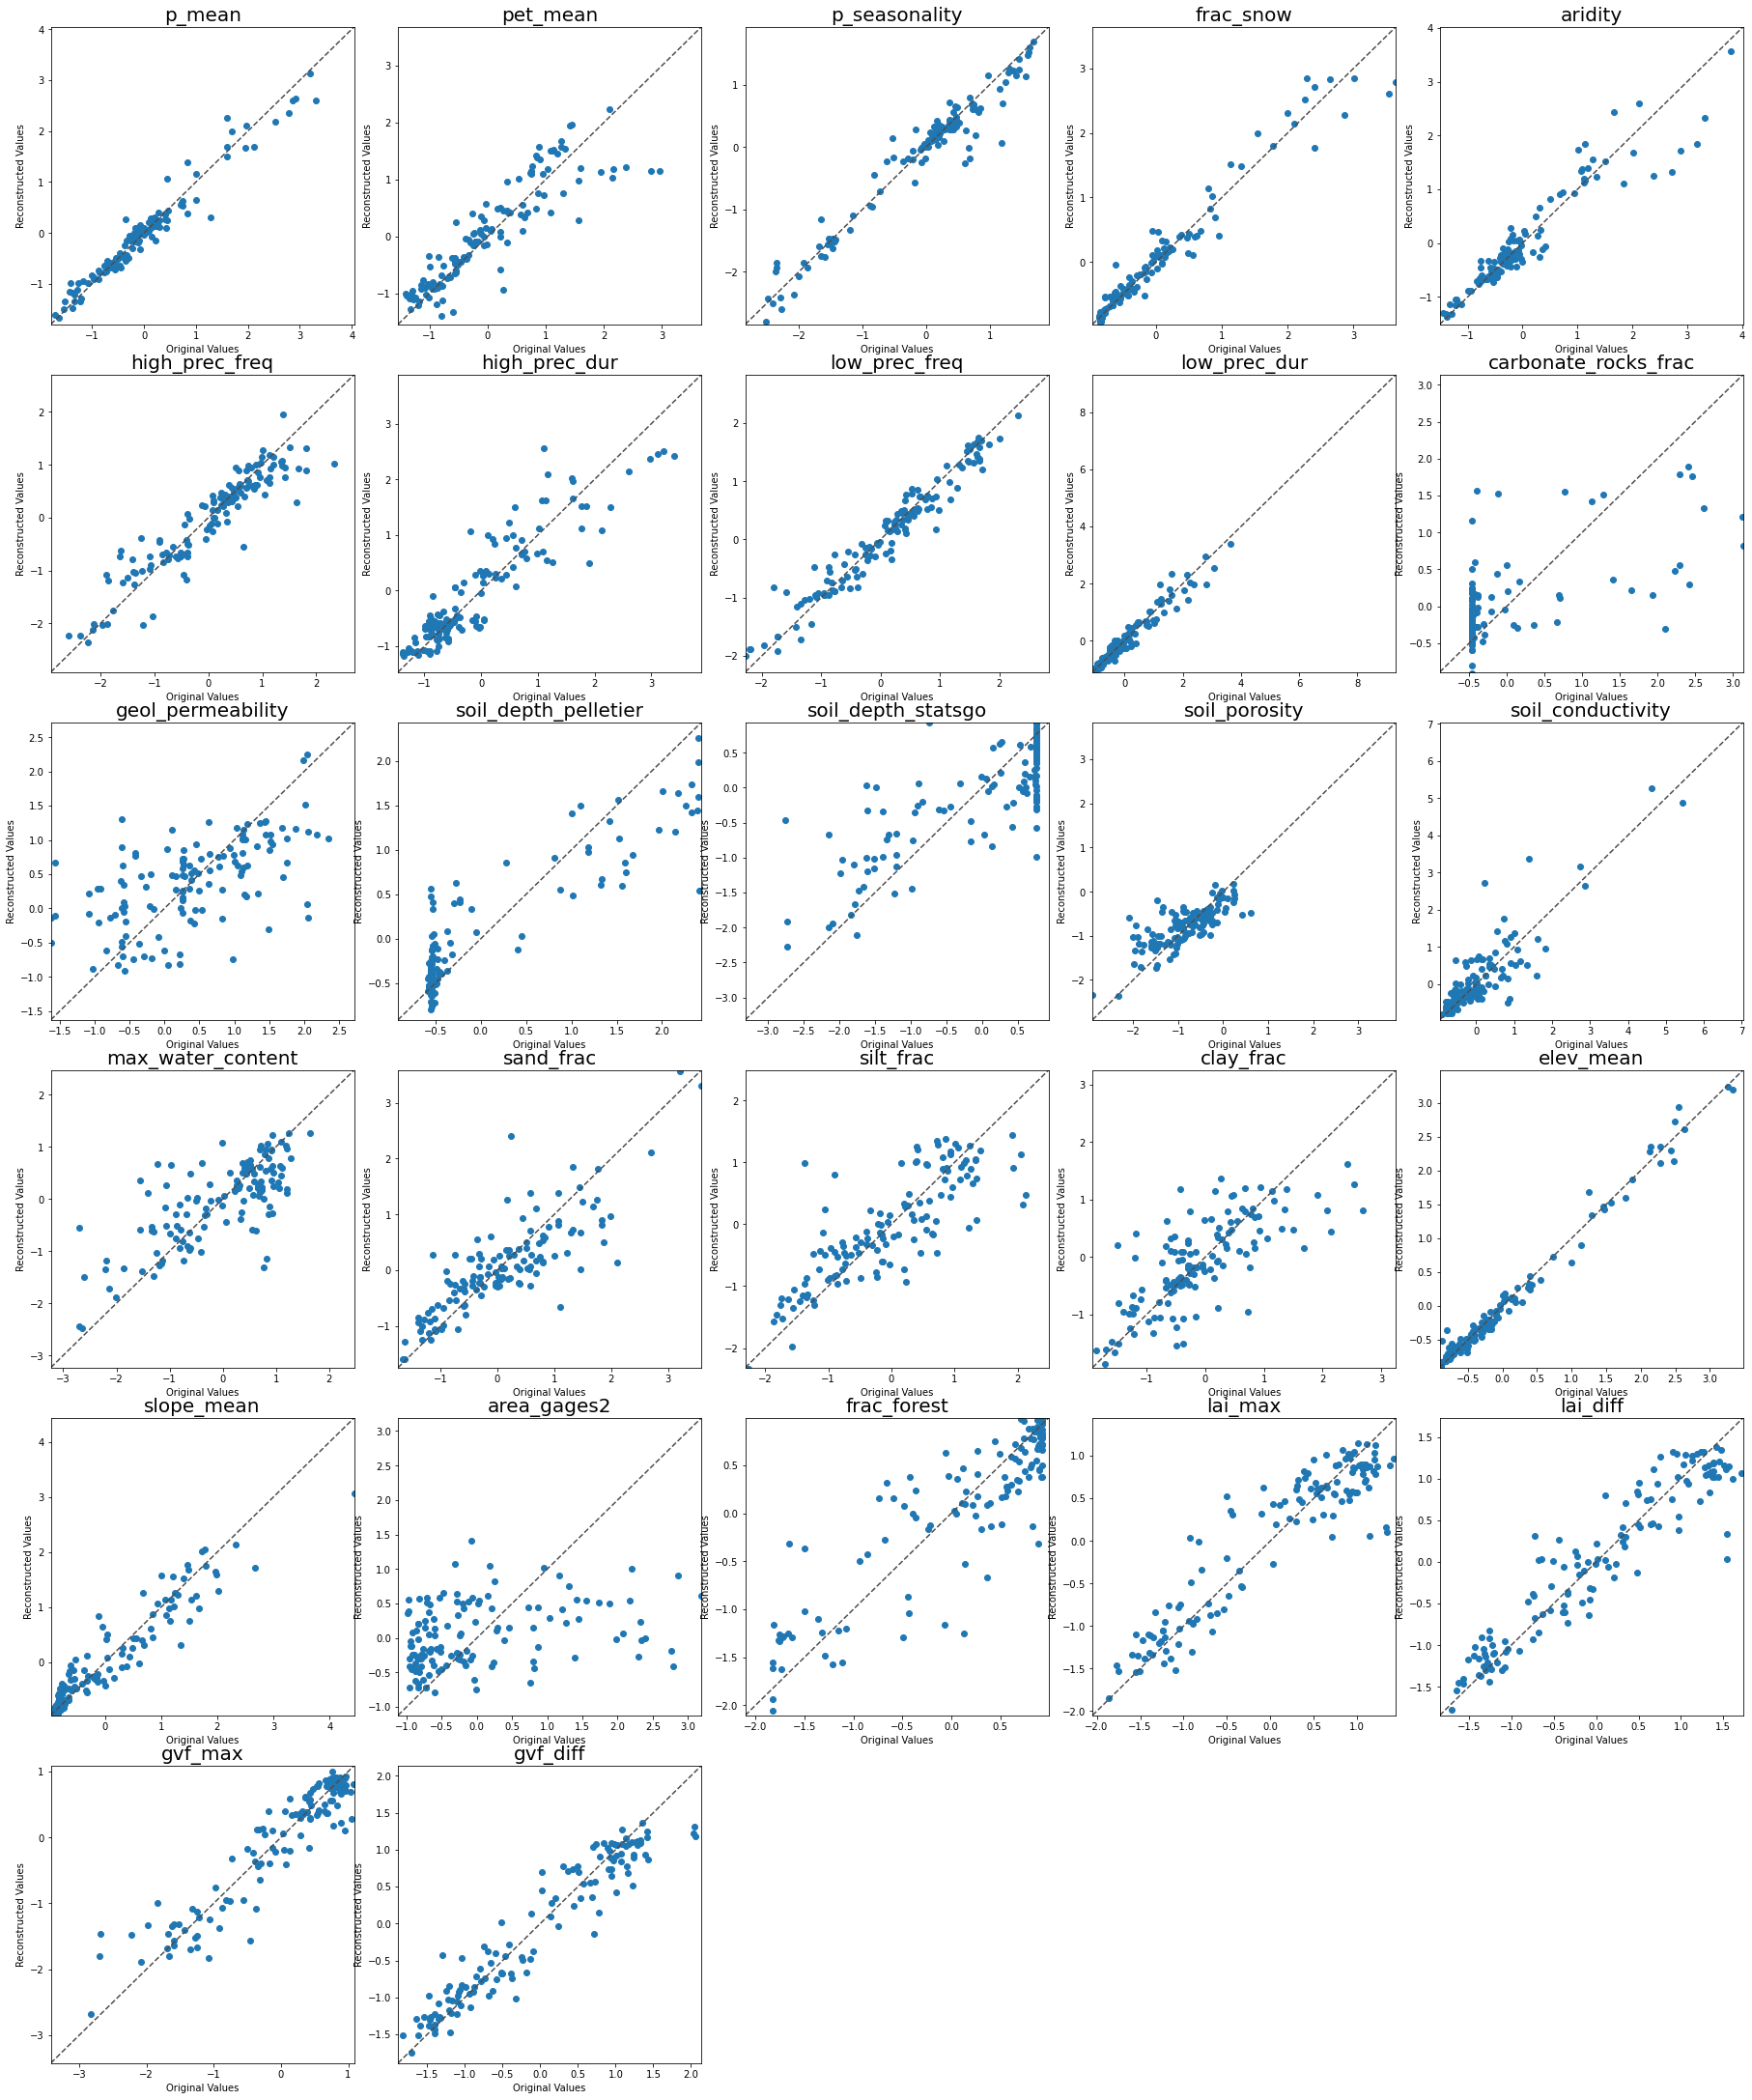

[0.21989709839743352, 0.44596876110511957, 0.24545950738835562, 0.21176725314539455, 0.3252562965467399, 0.3918909751814794, 0.43360136840404917, 0.24728742753253927, 0.22058809405409868, 0.6694697971500473, 0.7507998307510986, 0.4304826038705546, 0.6286794589738661, 0.41648188731234703, 0.4904717341729126, 0.6766018972282822, 0.5673062484132219, 0.5782398015469681, 0.632200733447432, 0.12158768779516593, 0.3248211830485871, 0.989445028161159, 0.4293942511616865, 0.3617701811034432, 0.34786014264971293, 0.33170141567430705, 0.3069388397216493]
0.43688775940509816


In [14]:

cols = 5
rows = 6
fontsize = 20
plt.figure(figsize=(5*cols, 5*rows))
minx = np.load(os.path.join(config.NUMPY_DIR, "minx.npy"))
maxx = np.load(os.path.join(config.NUMPY_DIR, "maxx.npy"))
miny = np.load(os.path.join(config.NUMPY_DIR, "miny.npy"))
maxy = np.load(os.path.join(config.NUMPY_DIR, "maxy.npy"))
print("Train Data:{}\tValidation Data:{}\tTest Data:{}".format(train_data.shape, validation_data.shape, test_data.shape))
rmse_feature = []
for feature,channel in enumerate(static_channels):
    input_val = np.zeros(input_dataset.shape[0])
    recon_val = np.zeros_like(input_val)
    for basin in range(input_dataset.shape[0]):
        input_val[basin] = input_dataset[basin,0,feature]
        recon_val[basin] = np.nanmean(np.nanmean((reconstructed_dataset_all_runs[:,basin,:-config.window//2,feature]), axis=0 ))
    plt.subplot(rows, cols, feature+1)
    plt.title("{}".format(feature_names[channel]), fontsize=fontsize)
    plt.xlabel("Original Values", fontsize=fontsize//2)
    plt.ylabel("Reconstructed Values", fontsize=fontsize//2)
    plt.ylim(miny[feature], maxy[feature])
    plt.xlim(miny[feature], maxy[feature])
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
    plt.scatter(input_val, recon_val)  
    rmse_feature.append(mean_squared_error(input_val, recon_val,squared=False))
plt.tight_layout(pad=0.0,h_pad=0.0,w_pad=0.0)
model_name2 = "Imputed_{}".format(int(num_hidden))
plt.savefig(os.path.join(config.RESULT_DIR, "{}_Meanwithline20yearsbasin_train".format(model_name2)))
plt.show()
print(rmse_feature)
print(mean(rmse_feature))

In [15]:
#Do predictions for test data during test period
dataset = test_data
reconstructed_dataset_all_runs = np.zeros((num_runs,dataset.shape[0], (1+(dataset.shape[1]//2))* dataset.shape[2], dataset.shape[3])).astype(np.float32)
for runs in range(1,(num_runs+1)):

    model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR,"{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}.pt".format("ALL", architecture, code_dim, len(static_channels), runs,batch_size,"{}_NL".format(num_layer),Hidden,recon_weight,static_weight,triplet_weight,temp))))
    model.eval()
    reconstructed_dataset1 = np.zeros((dataset.shape[0], (1+(dataset.shape[1]//2)), dataset.shape[2], dataset.shape[3])).astype(np.float32)
    input_dataset = np.zeros_like(reconstructed_dataset1).astype(np.float32)
    embedding = np.zeros((dataset.shape[0], dataset.shape[1], code_dim)).astype(np.float32)

    """Run model"""
    total_out = np.zeros((dataset.shape[0], dataset.shape[1], dataset.shape[2], dataset.shape[3])).astype(np.float32)
    train_static_out = np.zeros((dataset.shape[0],len(static_channels),dataset.shape[1])).astype(np.float32)
    train_static_input = np.zeros((dataset.shape[0],len(static_channels))).astype(np.float32)
    total_recon_loss = 0
    total_static_loss = 0
    for year in range(dataset.shape[1]):
        yearly_data = dataset[:, year]
        for batch in range(math.ceil(yearly_data.shape[0]/batch_size)):
            data = torch.from_numpy(yearly_data[batch*batch_size:(batch+1)*batch_size]).to(device)
            input_data = data[:,:,input_channels]
            static_data = data[:,0,static_channels]
            code_vec, reconstruction, static_reconstruction_mean = model(input_data.to(device))
            static_reconstruction = static_reconstruction_mean

            # Calculate reconstruction loss
            recon_loss = torch.sum(criterion(reconstruction, input_data), axis=2)
            recon_loss = torch.masked_select(recon_loss, (input_data[:,:,-1]!=config.unknown))
            recon_loss = torch.mean(recon_loss)
            total_recon_loss += recon_loss.item()

            # Calculate static loss
            static_loss = torch.mean(criterion(static_reconstruction, static_data), axis=1)
            static_loss = torch.masked_select(static_loss, (input_data[:,:,-1]!=config.unknown).all(axis=1))
            static_loss = torch.mean(static_loss)
            total_static_loss += static_loss.item()

            # Store outputs
            embedding[batch*batch_size:(batch+1)*batch_size,year] = code_vec.detach().cpu().numpy()
            total_out[batch*batch_size:(batch+1)*batch_size, year][:, :, input_channels] = reconstruction.detach().cpu().numpy()
            total_out[batch*batch_size:(batch+1)*batch_size, year][:, :, static_channels] = static_reconstruction.unsqueeze(dim=1).repeat(1, config.window, 1).detach().cpu().numpy()
            train_static_input[batch*batch_size:(batch+1)*batch_size] = static_data.cpu().numpy()
            #print(static_reconstruction.unsqueeze(dim=1).repeat(1, config.window, 1).detach().cpu().numpy().mean(axis=1)[35][10])

            train_static_out[batch*batch_size:(batch+1)*batch_size,:,year] = static_reconstruction.detach().cpu().numpy()
            #print(static_reconstruction.detach().cpu().numpy()[35][10])


            # Make unknown values to be NaN
            embedding[batch*batch_size:(batch+1)*batch_size,year][(input_data[:,:,-1]==config.unknown).all(axis=1).cpu().numpy()] = np.nan
            total_out[batch*batch_size:(batch+1)*batch_size, year][(input_data[:,:,-1]==config.unknown).all(axis=1).cpu().numpy()] = np.nan
    print('Reconstruction MSE:{:.4f}\tStatic MSE:{:.4f}'.format(total_recon_loss/((batch+1)*(year+1)), total_static_loss/((batch+1)*(year+1))))
    reconstructed_dataset1[:,:,:config.window//2+1] = total_out[:,::2][:,:,-(config.window//2)-1:]
    reconstructed_dataset1[:,:,config.window//2+1:] = np.concatenate((total_out[:,1::2][:,:,-(config.window//2):], np.zeros((dataset.shape[0],1,config.window//2, dataset.shape[3]))), axis=1)
    input_dataset[:,:,:config.window//2+1] = dataset[:,::2][:,:,-(config.window//2)-1:]
    input_dataset[:,:,config.window//2+1:] = np.concatenate((dataset[:,1::2][:,:,-(config.window//2):], np.zeros((dataset.shape[0],1,config.window//2, dataset.shape[3]))), axis=1)
    reconstructed_dataset1 = np.reshape(reconstructed_dataset1, (reconstructed_dataset1.shape[0], -1, reconstructed_dataset1.shape[3]))
    input_dataset = np.reshape(input_dataset, (input_dataset.shape[0], -1, input_dataset.shape[3]))
    #train_static = train_static_out[38]
    dummy = train_static_out[:,:,:-1]
    train_static = dummy.mean(axis = 2) 
    #train_static = train_static_out.mean(axis = 2) 
    print(train_static_out.mean(axis = 2).shape)
    print(dataset.shape, total_out.shape, reconstructed_dataset1.shape, input_dataset.shape, embedding.shape)  
    reconstructed_dataset_all_runs[runs-1] = reconstructed_dataset1

Reconstruction MSE:2.1459	Static MSE:0.3399
(131, 27)
(131, 19, 365, 33) (131, 19, 365, 33) (131, 3650, 33) (131, 3650, 33) (131, 19, 32)
Reconstruction MSE:2.1363	Static MSE:0.3501
(131, 27)
(131, 19, 365, 33) (131, 19, 365, 33) (131, 3650, 33) (131, 3650, 33) (131, 19, 32)
Reconstruction MSE:2.1452	Static MSE:0.3285
(131, 27)
(131, 19, 365, 33) (131, 19, 365, 33) (131, 3650, 33) (131, 3650, 33) (131, 19, 32)
Reconstruction MSE:2.0948	Static MSE:0.3419
(131, 27)
(131, 19, 365, 33) (131, 19, 365, 33) (131, 3650, 33) (131, 3650, 33) (131, 19, 32)
Reconstruction MSE:2.1074	Static MSE:0.3310
(131, 27)
(131, 19, 365, 33) (131, 19, 365, 33) (131, 3650, 33) (131, 3650, 33) (131, 19, 32)


In [16]:
# sigma_mean =sigma_all_runs.mean(axis=0)
# sigma_mean

In [17]:
#np.save(os.path.join(config.RESULT_DIR, "{}_Embeddings".format(model_name)), embedding)

In [18]:
from scipy.stats import pearsonr
from matplotlib import ticker

In [52]:
feature_names[9] = "carb_rocks_frac"
feature_names[10] = "geol_perm"
feature_names[11] = "soil_depth_pel"
feature_names[12] = "soil_depth_stat"
feature_names[14] = "soil_conduct"
feature_names[15] = "max_water_cont"

feature_names[:]
c_index = ["C{}".format(i) for i in range(1,10)]
g_index = ["S{}".format(i) for i in range(1,11)]
gm_index = ["G{}".format(i) for i in range(1,9)]
index_names = c_index+g_index+gm_index

array(['p_mean', 'pet_mean', 'p_seasonality', 'frac_snow', 'aridity',
       'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur',
       'carb_rocks_frac', 'geol_perm', 'soil_depth_pel',
       'soil_depth_stat', 'soil_porosity', 'soil_conduct',
       'max_water_cont', 'sand_frac', 'silt_frac', 'clay_frac',
       'elev_mean', 'slope_mean', 'area_gages2', 'frac_forest', 'lai_max',
       'lai_diff', 'gvf_max', 'gvf_diff', 'PRCP(mm/day)', 'SRAD(W/m2)',
       'Tmax(C)', 'Tmin(C)', 'Vp(Pa)', 'SF'], dtype='<U20')

(3, 9)
Train Data:(400, 13, 365, 33)	Validation Data:(400, 3, 365, 33)	Test Data:(131, 19, 365, 33)


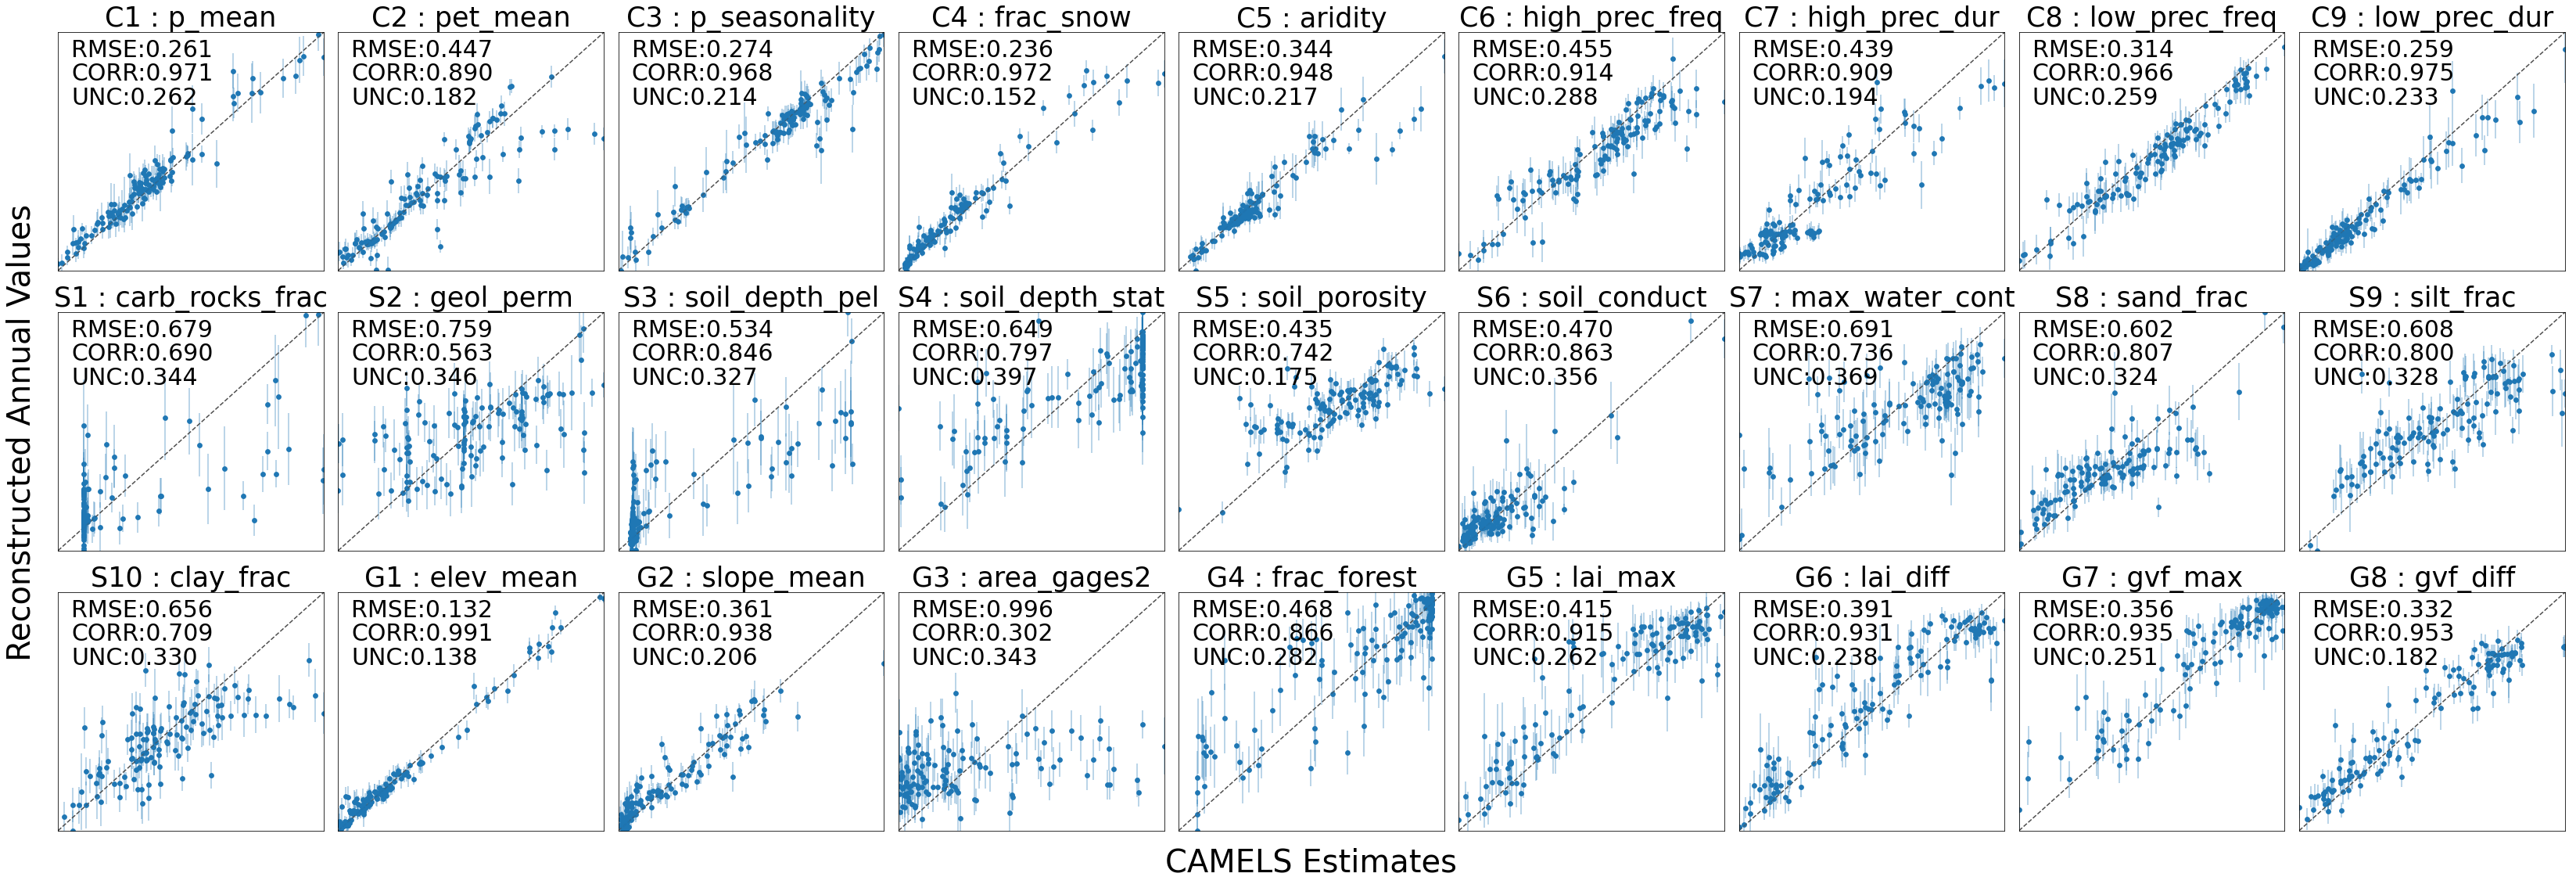

[0.261443373078359, 0.44698945928203243, 0.27428716438943335, 0.23605194225233891, 0.34385756637817105, 0.4551023976460783, 0.439033977285067, 0.31418636409498657, 0.25930428348032014, 0.6792139980091927, 0.7585193744449922, 0.5340685658736084, 0.6485488261103398, 0.4346254014073925, 0.4696161363172656, 0.6913356339135676, 0.6019275396862032, 0.6081475859332216, 0.6560105582464374, 0.13162490100081212, 0.36120958763922084, 0.996320015669943, 0.46834660632272046, 0.41505150091111326, 0.39110820182978695, 0.35587947180833385, 0.33163376558494656]
0.46531274809614387
[0.26192813218777417, 0.181649029311788, 0.2138684248651257, 0.15243228527767058, 0.21662714849901563, 0.28796050589503225, 0.19414990759305373, 0.2589708701458596, 0.233450677217418, 0.3439559373464293, 0.34577585335906225, 0.327127612558485, 0.3974633411369251, 0.17450504579389367, 0.3557861672557947, 0.36912021461788935, 0.3244022560938624, 0.32758945647541804, 0.3296981902067898, 0.13813318118794274, 0.2064283271782271, 0

In [73]:

cols = 9
rows = 3
fontsize = 30
fig, axes = plt.subplots(3, 9,figsize=(5*cols, 5*rows))
print(axes.shape)
fig.add_subplot(111, frameon=False)
# minx = np.load(os.path.join(config.NUMPY_DIR, "minx.npy"))
# maxx = np.load(os.path.join(config.NUMPY_DIR, "maxx.npy"))
# miny = np.load(os.path.join(config.NUMPY_DIR, "miny.npy"))
# maxy = np.load(os.path.join(config.NUMPY_DIR, "maxy.npy"))
print("Train Data:{}\tValidation Data:{}\tTest Data:{}".format(train_data.shape, validation_data.shape, test_data.shape))
rmse_feature = []
std_feature = []
reconstructed_test_basin_data = np.zeros((input_dataset.shape[0],len(static_channels)))
row =0
for feature,channel in enumerate(static_channels):
    input_val = np.zeros(input_dataset.shape[0])
    recon_val = np.zeros_like(input_val)
    std_recon_val = np.zeros_like(input_val)
    for basin in range(input_dataset.shape[0]):
        input_val[basin] = input_dataset[basin,0,feature]
        recon_val[basin] = np.nanmean(np.nanmean((reconstructed_dataset_all_runs[:,basin,:-config.window//2,feature]), axis=0 ))
        #std_recon_val[basin] = np.nanstd(np.nanmean((reconstructed_dataset_all_runs[:,basin,:-config.window//2,feature]), axis=0 ))
        std_recon_val[basin] = np.nanstd(reconstructed_dataset_all_runs[:,basin,:-config.window//2,feature]) 
        reconstructed_test_basin_data[basin,feature] = recon_val[basin]
    axes[row,(feature)%9].set_title("{}".format(index_names[channel]+" : "+feature_names[channel]), fontsize=35)
    axes[row,(feature)%9].set_xlim(min(np.nanmin(input_val),np.nanmin(recon_val)), max(np.nanmax(input_val),np.nanmax(recon_val)))
    axes[row,(feature)%9].set_ylim(min(np.nanmin(input_val),np.nanmin(recon_val)), max(np.nanmax(input_val),np.nanmax(recon_val)))


    axes[row,(feature)%9].plot(axes[row,(feature)%9].get_xlim(), axes[row,(feature)%9].get_ylim(), ls="--", c=".3")
    axes[row,(feature)%9].scatter(input_val, recon_val,s=30 )  
    axes[row,(feature)%9].text(0.05,0.9,"RMSE:{0:.3f}".format(mean_squared_error(input_val, recon_val,squared=False)),fontsize=30,transform=axes[row,(feature)%9].transAxes)
    axes[row,(feature)%9].text(0.05,0.8,"CORR:{0:.3f}".format(pearsonr(input_val, recon_val)[0]),fontsize=30,transform=axes[row,(feature)%9].transAxes)
    axes[row,(feature)%9].text(0.05,0.7,"UNC:{0:.3f}".format(mean(std_recon_val)),fontsize=30,transform=axes[row,(feature)%9].transAxes)
    std_feature.append(mean(std_recon_val))
    rmse_feature.append(mean_squared_error(input_val, recon_val,squared=False))
    # Create your ticker object with M ticks
    M = 5
    yticks = ticker.MaxNLocator(M)
    xticks = ticker.MaxNLocator(M)
    # Set the yaxis major locator using your ticker object. You can also choose the minor
    # tick positions with set_minor_locator.
    axes[row,(feature)%9].yaxis.set_major_locator(yticks)
    axes[row,(feature)%9].xaxis.set_major_locator(xticks)
    axes[row,(feature)%9].set_xticks([])
    axes[row,(feature)%9].set_yticks([])
    axes[row,(feature)%9].errorbar(input_val, recon_val, yerr=std_recon_val, fmt="o",alpha=0.4)#,color='red')    
    if((feature+1)%9 ==0):
        row+=1
plt.tight_layout(pad=0,h_pad=1.5,w_pad=1.5)
plt.tick_params(labelcolor='none', which='both', bottom=False, left=False, right=False)
plt.xlabel("CAMELS Estimates",fontsize=40)
plt.ylabel("Reconstructed Annual Values",fontsize=40)

model_name2 = "Imputed_{}_static_wt={}_{}".format(int(num_hidden),int(static_weight),Hidden)
plt.savefig(os.path.join(config.RESULT_DIR, "{}_basin_test.pdf".format(model_name2)),bbox_inches = 'tight')
plt.show()
print(rmse_feature)
print(mean(rmse_feature))
print(std_feature)

(3, 9)
Train Data:(400, 13, 365, 33)	Validation Data:(400, 3, 365, 33)	Test Data:(131, 19, 365, 33)


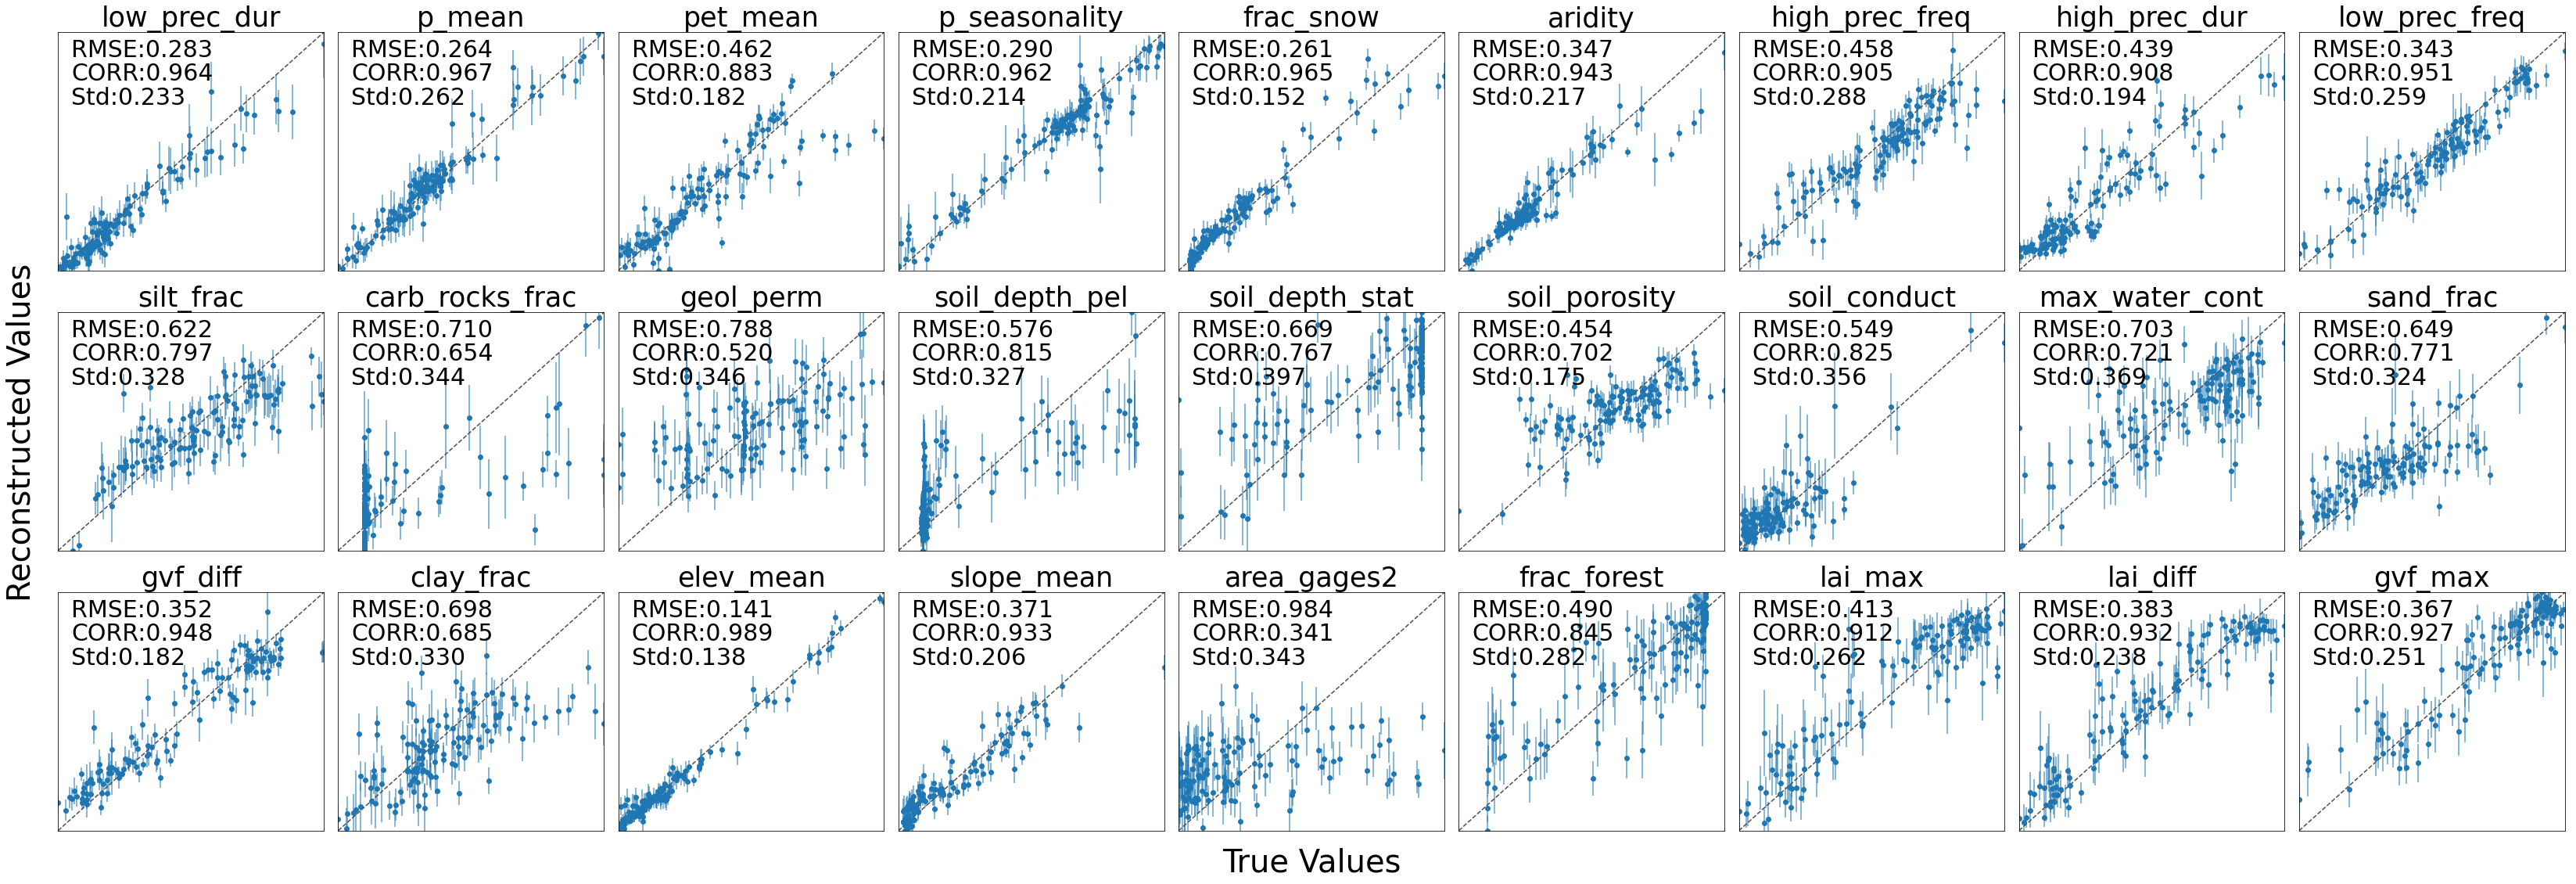

[0.2641167986944295, 0.46180740750635996, 0.29037506375064226, 0.2613320253691504, 0.3472779761420165, 0.457722416995038, 0.4392993693208655, 0.34276697401555706, 0.2833448776588386, 0.70996896519394, 0.7879420513025014, 0.5755677495572508, 0.668577815689637, 0.45415341279079363, 0.5492658685435263, 0.7026441177794103, 0.6493542520752716, 0.6219349318210148, 0.698128429592085, 0.14117506133037466, 0.3713940864896236, 0.984181662635698, 0.4902471242948526, 0.41290850700841913, 0.3834969080934036, 0.3673433414127465, 0.3518299831678804]
0.4840058214159751
[0.26192813218777417, 0.181649029311788, 0.2138684248651257, 0.15243228527767058, 0.21662714849901563, 0.28796050589503225, 0.19414990759305373, 0.2589708701458596, 0.233450677217418, 0.3439559373464293, 0.34577585335906225, 0.327127612558485, 0.3974633411369251, 0.17450504579389367, 0.3557861672557947, 0.36912021461788935, 0.3244022560938624, 0.32758945647541804, 0.3296981902067898, 0.13813318118794274, 0.2064283271782271, 0.3425253637

In [63]:
# Plot real vs predicted but also save the average predicted value of 5 runs in reconstructed for future processing
cols = 9
rows = 3
fontsize = 30
fig, axes = plt.subplots(3, 9,figsize=(5*cols, 5*rows))
print(axes.shape)
fig.add_subplot(111, frameon=False)
# minx = np.load(os.path.join(config.NUMPY_DIR, "minx.npy"))
# maxx = np.load(os.path.join(config.NUMPY_DIR, "maxx.npy"))
# miny = np.load(os.path.join(config.NUMPY_DIR, "miny.npy"))
# maxy = np.load(os.path.join(config.NUMPY_DIR, "maxy.npy"))
print("Train Data:{}\tValidation Data:{}\tTest Data:{}".format(train_data.shape, validation_data.shape, test_data.shape))
rmse_feature = []
std_feature = []
corr_feature =[]
reconstructed_test_basin_data = np.zeros((input_dataset.shape[0],len(static_channels)))
row =0
for feature,channel in enumerate(static_channels):
    input_val = np.zeros(input_dataset.shape[0])
    recon_val = np.zeros_like(input_val)
    std_recon_val = np.zeros_like(input_val)
    for basin in range(input_dataset.shape[0]):
        input_val[basin] = input_dataset[basin,0,feature]
        recon_val[basin] = np.nanmean(reconstructed_dataset_all_runs[0,basin,:-config.window//2,feature])
        #std_recon_val[basin] = np.nanstd(np.nanmean((reconstructed_dataset_all_runs[:,basin,:-config.window//2,feature]), axis=0 ))
        std_recon_val[basin] = np.nanstd(reconstructed_dataset_all_runs[:,basin,:-config.window//2,feature]) 
        reconstructed_test_basin_data[basin,feature] = recon_val[basin]

    axes[row,(feature+1)%9].set_title("{}".format(feature_names[channel]), fontsize=35)
    axes[row,(feature+1)%9].set_xlim(min(np.nanmin(input_val),np.nanmin(recon_val)), max(np.nanmax(input_val),np.nanmax(recon_val)))
    axes[row,(feature+1)%9].set_ylim(min(np.nanmin(input_val),np.nanmin(recon_val)), max(np.nanmax(input_val),np.nanmax(recon_val)))

    axes[row,(feature+1)%9].plot(axes[row,(feature+1)%9].get_xlim(), axes[row,(feature+1)%9].get_ylim(), ls="--", c=".3")
    axes[row,(feature+1)%9].scatter(input_val, recon_val ,s=30)  
    axes[row,(feature+1)%9].text(0.05,0.9,"RMSE:{0:.3f}".format(mean_squared_error(input_val, recon_val,squared=False)),fontsize=30,transform=axes[row,(feature+1)%9].transAxes)
    axes[row,(feature+1)%9].text(0.05,0.8,"CORR:{0:.3f}".format(pearsonr(input_val, recon_val)[0]),fontsize=30,transform=axes[row,(feature+1)%9].transAxes)
    axes[row,(feature+1)%9].text(0.05,0.7,"Std:{0:.3f}".format(mean(std_recon_val)),fontsize=30,transform=axes[row,(feature+1)%9].transAxes)
    std_feature.append(mean(std_recon_val))
    rmse_feature.append(mean_squared_error(input_val, recon_val,squared=False))
    corr_feature.append(pearsonr(input_val, recon_val)[0])
    # Create your ticker object with M ticks
    M = 5
    yticks = ticker.MaxNLocator(M)
    xticks = ticker.MaxNLocator(M)
    # Set the yaxis major locator using y5our ticker object. You can also choose the minor
    # tick positions with set_minor_locator.
    axes[row,(feature+1)%9].yaxis.set_major_locator(yticks)
    axes[row,(feature+1)%9].xaxis.set_major_locator(xticks)
    axes[row,(feature+1)%9].errorbar(input_val, recon_val, yerr=std_recon_val, fmt="o",alpha=0.7)#,color='red')
    axes[row,(feature+1)%9].set_xticks([])
    axes[row,(feature+1)%9].set_yticks([])
    if((feature+1)%9 ==0):
        row+=1
plt.tight_layout(pad=0,h_pad=1.5,w_pad=1.5)
plt.tick_params(labelcolor='none', which='both', bottom=False, left=False, right=False)
plt.xlabel("True Values",fontsize=40)
plt.ylabel("Reconstructed Values",fontsize=40)
model_name2 = "Imputed_{}_static_wt={}_{}".format(int(num_hidden),int(static_weight),Hidden)
plt.savefig(os.path.join(config.RESULT_DIR, "{}_basin_test_error_bar.pdf".format(model_name2)),bbox_inches = 'tight')
plt.show()
print(rmse_feature)
print(mean(rmse_feature))
print(std_feature)
print(mean(corr_feature))

In [23]:
reconstructed_test_basin_data.shape

(131, 27)

In [24]:
np.save(os.path.join(config.RESULT_DIR, "{}_clean_reconstructed_test_basins".format(model_name)), reconstructed_test_basin_data)